In [1]:

# ------------------------------------
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
# ------------------------------------


import os
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import CodeInterpreterTool
from azure.identity import DefaultAzureCredential
from typing import Any
from pathlib import Path
from dotenv import load_dotenv

# Create an Azure AI Client from a connection string, copied from your Azure AI Foundry project.
# At the moment, it should be in the format "<HostName>;<AzureSubscriptionId>;<ResourceGroup>;<ProjectName>"
# HostName can be found by navigating to your discovery_url and removing the leading "https://" and trailing "/discovery"
# To find your discovery_url, run the CLI command: az ml workspace show -n {project_name} --resource-group {resource_group_name} --query discovery_url
# Project Connection example: eastus.api.azureml.ms;12345678-abcd-1234-9fc6-62780b3d3e05;my-resource-group;my-project-name
# Customer needs to login to Azure subscription via Azure CLI and set the environment variables

load_dotenv()
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_GPT4o_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_GPT4o_DEPLOYMENT_NAME")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
AZURE_AISTUDIO_PROJECT_CONN_STRING = os.getenv("AZURE_AISTUDIO_PROJECT_CONN_STRING")

In [4]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str=AZURE_AISTUDIO_PROJECT_CONN_STRING
)

with project_client:
    # Create an instance of the CodeInterpreterTool
    code_interpreter = CodeInterpreterTool()

    # The CodeInterpreterTool needs to be included in creation of the agent
    agent = project_client.agents.create_agent(
        model=AZURE_OPENAI_GPT4o_DEPLOYMENT_NAME,
        name="my-agent",
        instructions="You are helpful agent",
        tools=code_interpreter.definitions,
        tool_resources=code_interpreter.resources,
    )
    print(f"Created agent, agent ID: {agent.id}")

    # Create a thread
    thread = project_client.agents.create_thread()
    print(f"Created thread, thread ID: {thread.id}")

    # Create a message
    message = project_client.agents.create_message(
        thread_id=thread.id,
        role="user",
        content="Could you please create a bar chart for the operating profit using the following data and provide the file to me? Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, Company D: $1.8 million",
    )
    print(f"Created message, message ID: {message.id}")

    # Run the agent
    run = project_client.agents.create_and_process_run(thread_id=thread.id, assistant_id=agent.id)
    print(f"Run finished with status: {run.status}")

    if run.status == "failed":
        # Check if you got "Rate limit is exceeded.", then you want to get more quota
        print(f"Run failed: {run.last_error}")

    # Get messages from the thread
    messages = project_client.agents.list_messages(thread_id=thread.id)
    print(f"Messages: {messages}")

    # Get the last message from the sender
    last_msg = messages.get_last_text_message_by_role("assistant")
    if last_msg:
        print(f"Last Message: {last_msg.text.value}")

    target_dir = f"{Path.cwd()}/output/"
    file_name=""
    # Generate an image file for the bar chart
    for image_content in messages.image_contents:
        print(f"Image File ID: {image_content.image_file.file_id}")
        file_name = f"{image_content.image_file.file_id}_image_file.png"
        project_client.agents.save_file(file_id=image_content.image_file.file_id, file_name=file_name, target_dir=target_dir)
        print(f"Saved image file to: {target_dir}/{file_name}")

    # Print the file path(s) from the messages
    for file_path_annotation in messages.file_path_annotations:
        print(f"File Paths:")
        print(f"Type: {file_path_annotation.type}")
        print(f"Text: {file_path_annotation.text}")
        print(f"File ID: {file_path_annotation.file_path.file_id}")
        print(f"Start Index: {file_path_annotation.start_index}")
        print(f"End Index: {file_path_annotation.end_index}")
        # project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=Path(file_path_annotation.text).name)

    # Delete the agent once done
    project_client.agents.delete_agent(agent.id)
    print("Deleted agent")

Created agent, agent ID: asst_wY3s5J7o7kHyvAn2Wz51yRzc
Created thread, thread ID: thread_ZbyFfBKfb7Hue5KGXHfqAGWI
Created message, message ID: msg_KqVZjEpHRWHgxQSGOMVXVuod
Run finished with status: completed
Messages: {'object': 'list', 'data': [{'id': 'msg_QFLrIWcHVoIn790dfAQvlfcf', 'object': 'thread.message', 'created_at': 1739109660, 'assistant_id': 'asst_wY3s5J7o7kHyvAn2Wz51yRzc', 'thread_id': 'thread_ZbyFfBKfb7Hue5KGXHfqAGWI', 'run_id': 'run_jyhAYX4A7UIyfvZoTAYpWJRk', 'role': 'assistant', 'content': [{'type': 'image_file', 'image_file': {'file_id': 'assistant-UUlB0s0TPXbgDa2wmVMeWlZJ'}}, {'type': 'text', 'text': {'value': 'I have created the bar chart for the operating profit of the specified companies. You can download the file using the link below:\n\n[Download Operating Profit Bar Chart](sandbox:/mnt/data/operating_profit_bar_chart.png)', 'annotations': [{'type': 'file_path', 'text': 'sandbox:/mnt/data/operating_profit_bar_chart.png', 'start_index': 169, 'end_index': 217, 'file

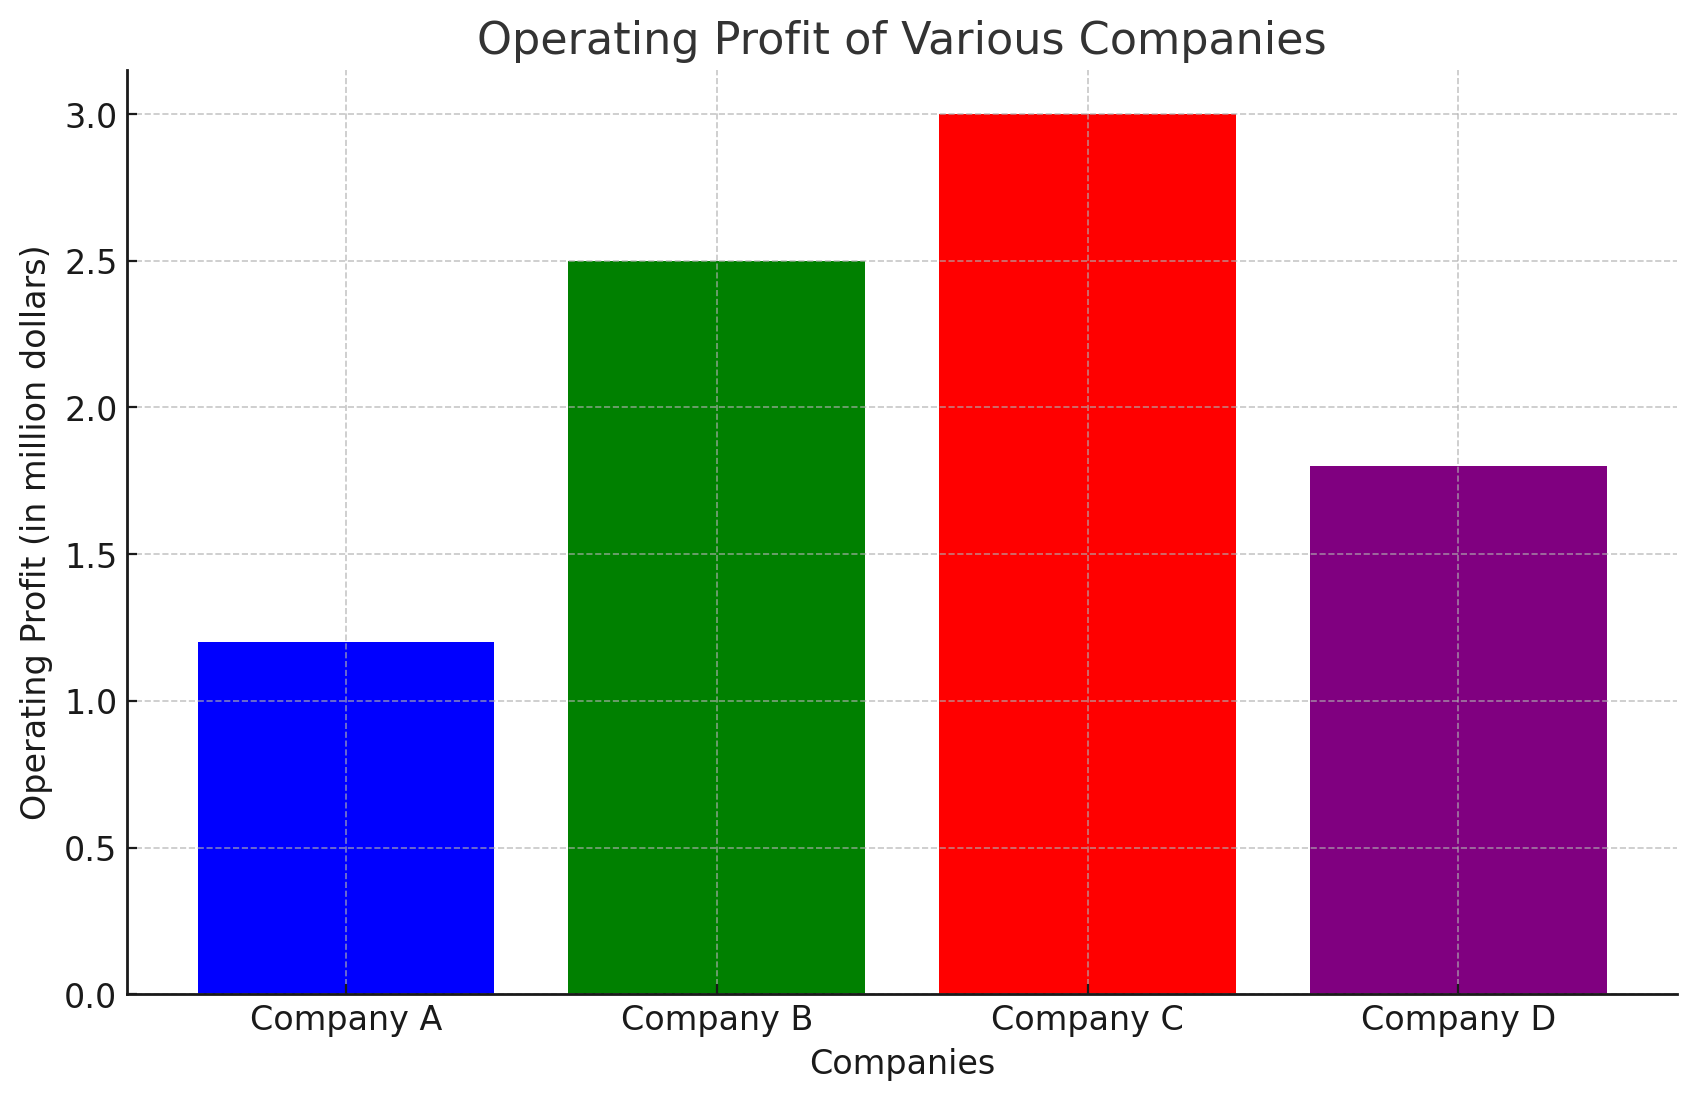

In [5]:
from IPython.display import display, HTML, JSON, Markdown, Image

display(Image(target_dir+file_name))